In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import Estimator, Sampler
from qiskit.quantum_info import SparsePauliOp
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2,RealAmplitudes

import pandas as pd
import shap

In [65]:
n_qubits = 4
n_samples = 500
directory="QCNN_dataset"

In [66]:
sampler = Sampler()
estimator = Estimator()
ob = SparsePauliOp.from_list([("Z"+"I"*(n_qubits-1), 1)])
print(ob)

SparsePauliOp(['ZIII'],
              coeffs=[1.+0.j])


In [67]:
all_op = ['I','X','Y','Z']
all_pauli = ['X','Y','Z']
ob_list4 = []
ob_list4_string = []
for a in all_op:
    for b in all_op:
        for c in all_op:
            for d in all_op:
                
                pauli = a+b+c+d
                if pauli != 'IIII':
                    op = SparsePauliOp.from_list([(pauli, 1)])
                    ob_list4.append(op)
                    ob_list4_string.append(pauli)

In [96]:
ob_list4_string = np.array(ob_list4_string)

In [68]:
#getting operators with symmetry:
ob_sym = [
#          SparsePauliOp.from_list([("XIII", 1)]),
#          SparsePauliOp.from_list([("YIII", 1)]),
#          SparsePauliOp.from_list([("ZIII", 1)]),
         ]



for a in all_pauli:
    
    ob = SparsePauliOp.from_list([(a+"III", 1)])
    ob_sym.append(ob)
    
    ob = SparsePauliOp.from_list([("I"+a+"II", 1)])
    ob_sym.append(ob)
    
    ob = SparsePauliOp.from_list([("II"+a+"I", 1)])
    ob_sym.append(ob)

    ob = SparsePauliOp.from_list([("III"+a, 1)])
    ob_sym.append(ob)
    
    for b in all_pauli:
        ob = SparsePauliOp.from_list([(a+b+"II", 1)])
        ob_sym.append(ob)
         
        ob = SparsePauliOp.from_list([("I"+a+b+"I", 1)])
        ob_sym.append(ob)
        
        ob = SparsePauliOp.from_list([("II"+a+b, 1)])
        ob_sym.append(ob)
        
        ob = SparsePauliOp.from_list([(a+"I"+b+"I", 1)])
        ob_sym.append(ob)
        ob = SparsePauliOp.from_list([("I"+a+"I"+b, 1)])
        ob_sym.append(ob)
    

In [69]:
len(ob_list4)

255

In [70]:
len(ob_sym)

57

In [71]:
deck = list(range(0, len(ob_list4)))
np.random.shuffle(deck)
index=deck[0:len(ob_sym)]

ob_random = []
for i in range(len(ob_list4)):
    
    if i in index:
        ob_random.append(ob_list4[i])

In [72]:
def addConv(qc,i1,i2,weights):
    '''
    Adding the convolution layer,
    qc: The circuit
    i1: The index of the first qubit in the convolution
    i2: The index of the second qubit in the convolution
    weights: Weights for all parameters in the convolution block
    '''
    # 15 parameters in total
    params_index=0
    #single qubit rotations
    qc.rz(weights[params_index],i1)
    params_index+=1
    qc.ry(weights[params_index],i1)
    params_index+=1
#     qc.rx(weights[params_index],i1)
#     params_index+=1
    
    qc.rz(weights[params_index],i2)
    params_index+=1
    qc.ry(weights[params_index],i2)
    params_index+=1
#     qc.rx(weights[params_index],i2)
#     params_index+=1
    
    #two qubits rotations
    qc.rzz(weights[params_index],i1,i2)
    params_index+=1
    qc.ryy(weights[params_index],i1,i2)
    params_index+=1
#     qc.rxx(weights[params_index],i1,i2)
#     params_index+=1
    
    ##single qubit rotations
#     qc.rz(weights[params_index],i1)
#     params_index+=1
#     qc.ry(weights[params_index],i1)
#     params_index+=1
#     qc.rx(weights[params_index],i1)
#     params_index+=1
    
#     qc.rz(weights[params_index],i2)
#     params_index+=1
#     qc.ry(weights[params_index],i2)
#     params_index+=1
#     qc.rx(weights[params_index],i2)
    
    qc.barrier()
    
    
def addPooling(qc,i1,i2,weights):
    '''
    Adding the pooling layer,
    qc: The circuit
    i1: The index of the first qubit in the pooling
    i2: The index of the second qubit in the pooling
    weights: Weights for all parameters in the pooling block
    '''
    params_index=0
    qc.rz(weights[params_index],i1)
    params_index += 1
    qc.ry(weights[params_index],i1)
    params_index += 1
#     qc.rx(weights[params_index],i1)
#     params_index += 1
    
    qc.rz(weights[params_index],i2)
    params_index += 1
    qc.ry(weights[params_index],i2)
#     params_index += 1
#     qc.rx(weights[params_index],i2)

    qc.cx(i1,i2)

    #qc.rx(-weights[params_index],i2)
#     qc.ry(-weights[params_index-1],i2)
#     qc.rz(-weights[params_index-2],i2)

    qc.barrier()

In [73]:
#Create datasets:
from qiskit.circuit import ParameterVector

n_reps_init=3
qc_init = QuantumCircuit(n_qubits)
ansatz_init =  EfficientSU2(num_qubits=n_qubits,reps=n_reps_init,parameter_prefix='init')
#ansatz_init =  RealAmplitudes(num_qubits=n_qubits,reps=n_reps_init,parameter_prefix='w')
qc_init.compose(ansatz_init, inplace=True)  

qc = QuantumCircuit(n_qubits)
ansatz_init2 =  EfficientSU2(num_qubits=n_qubits,reps=n_reps_init,parameter_prefix='init2')
qc.compose(ansatz_init2, inplace=True)  
qc.barrier()
# ansatz =  RealAmplitudes(num_qubits=n_qubits,reps=L,parameter_prefix='a')
# qc_all.compose(ansatz,inplace=True)

n_layers=1
n_convWeights=15-6-3
n_poolingWeights=6-2
# five conv blocks and 3 pooling blocks
n_params=n_convWeights*5 +n_poolingWeights*3
weights = ParameterVector("weight", n_params)
params_index=0

###################
#Convolution layer:
###################
index_start=0
index_end=n_convWeights
weights_conv1=weights[index_start:index_end]
    
for i in np.arange(0,n_qubits-1,1): #Convoluting all qubits from 0th to the last
    addConv(qc,i,i+1,weights_conv1)
qc.barrier()

###############
#pooling layer:
###############
index_start=index_end
index_end+=n_poolingWeights
weights_pooling1=weights[index_start:index_end]

for i in np.arange(0,int(n_qubits/2),1): #Pooling every two qubits
    addPooling(qc,i*2,i*2+1,weights_pooling1)
qc.barrier()

####################
#Convolution layer2:
####################
index_start=index_end
index_end=index_start+n_convWeights
weights_conv2=weights[index_start:index_end]
for i in np.arange(0,int(n_qubits/4),1): #Convoluting the remaining ones
    addConv(qc,i*4+1,i*4+3,weights_conv2)
 
################
#pooling layer2:
################
index_start=index_end
index_end+=n_poolingWeights
weights_pooling2=weights[index_start:index_end]
for i in np.arange(0,int(n_qubits/4),1):
    addPooling(qc,i*4+1,i*4+3,weights_pooling2)

qc.barrier()




VQA_params = 2*np.pi*np.random.rand(qc.num_parameters-qc_init.num_parameters)

 

/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


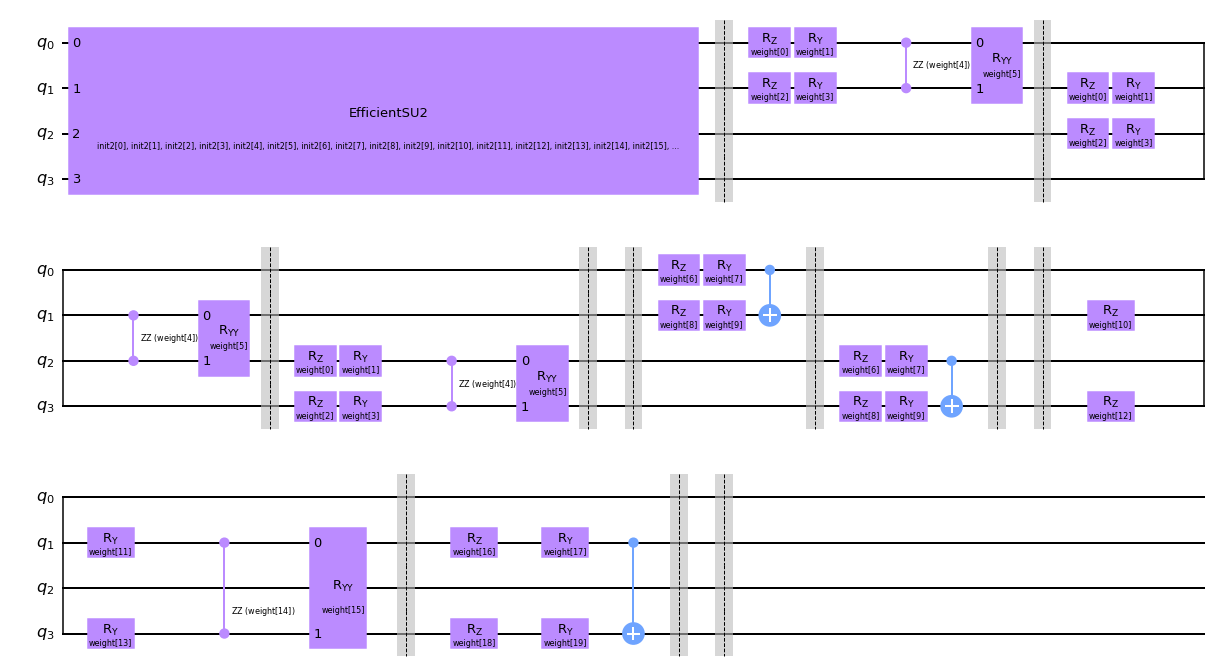

In [74]:
qc.draw('mpl')

In [75]:
param_init_list = []
info_sym_list = []
info_random_list = []
info_all_list = []
output_list = []

for i in range(n_samples):
    if i%10==0:
        print(i," samples prepared")
    param_init=2*np.pi*np.random.rand(qc_init.num_parameters)
    #params_all = np.concatenate([VQA_params,param_init])
    params_all = np.concatenate([param_init,VQA_params])

    info_random = estimator.run([qc_init]*len(ob_random),observables=ob_random,parameter_values=[param_init]*len(ob_random)).result().values
    info_sym = estimator.run([qc_init]*len(ob_sym),observables=ob_sym,parameter_values=[param_init]*len(ob_sym)).result().values
    info_all = estimator.run([qc_init]*len(ob_list4),observables=ob_list4,parameter_values=[param_init]*len(ob_list4)).result().values
    output = estimator.run(qc,observables=ob,parameter_values=params_all).result().values[0]
    #print(output)

    param_init_list.append(param_init)
    info_random_list.append(info_random)
    info_sym_list.append(info_sym)
    info_all_list.append(info_all)
    output_list.append(output)

param_init_list = np.array(param_init_list)
info_sym_list = np.array(info_sym_list)
info_random_list = np.array(info_random_list)
info_all_list = np.array(info_all_list)
output_list = np.array(output_list)
    
#turning into classification problem:
output_list=np.floor(output_list)+1
    
    

0  samples prepared
10  samples prepared
20  samples prepared
30  samples prepared
40  samples prepared
50  samples prepared
60  samples prepared
70  samples prepared
80  samples prepared
90  samples prepared
100  samples prepared
110  samples prepared
120  samples prepared
130  samples prepared
140  samples prepared
150  samples prepared
160  samples prepared
170  samples prepared
180  samples prepared
190  samples prepared
200  samples prepared
210  samples prepared
220  samples prepared
230  samples prepared
240  samples prepared
250  samples prepared
260  samples prepared
270  samples prepared
280  samples prepared
290  samples prepared
300  samples prepared
310  samples prepared
320  samples prepared
330  samples prepared
340  samples prepared
350  samples prepared
360  samples prepared
370  samples prepared
380  samples prepared
390  samples prepared
400  samples prepared
410  samples prepared
420  samples prepared
430  samples prepared
440  samples prepared
450  samples prepared

In [13]:
# info_sym_list = np.concatenate([info_sym_list,np.load("info_sym_list.npy")])
# info_random_list = np.concatenate([info_random_list,np.load("info_random_list.npy")])
# output_list = np.concatenate([output_list,np.load("output_list.npy")])


np.save("info_sym_list",info_sym_list)
np.save("info_random_list",info_random_list)
np.save("info_all_list",info_all_list)
np.save("output_list",output_list)

# info_sym_list = np.load("info_sym_list.npy")
# info_random_list = np.load("info_random_list.npy")
# output_list = np.load("output_list.npy")


In [14]:
#classical NN:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [15]:
info_all_list = pd.DataFrame(info_all_list,columns = ob_list4_string)

In [16]:
X_train_sym, X_test_sym, y_train_sym, y_test_sym = train_test_split(
       info_sym_list, output_list, test_size=0.1, random_state=42)

# X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(
#        info_random_list, output_list, test_size=0.1, random_state=42)

X_train_all, X_test_all, y_train_all, y_test_all= train_test_split(
       info_all_list, output_list, test_size=0.1, random_state=42)




In [31]:
def train(X_train,y_train,regularization = 0.001,loss_fn = tf.keras.losses.BinaryCrossentropy()):
    n_neurons=100
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(n_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization )),
        tf.keras.layers.Dense(n_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization )),
        tf.keras.layers.Dense(n_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization )),
        tf.keras.layers.Dense(n_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization )),
        
        tf.keras.layers.Dense(1, activation='sigmoid'),  
    ])

    model.compile(optimizer="adam",
                  loss=loss_fn,
                 metrics=['BinaryCrossentropy','accuracy'])

    best_model_path="bestmodel"
    save_best_model = tf.keras.callbacks.ModelCheckpoint(best_model_path, monitor='val_loss', 
                                      save_best_only=True, save_weights_only=True)

    history = model.fit(X_train, y_train, validation_split = 0.1 ,epochs=150,callbacks=[save_best_model])
    model.load_weights(best_model_path)
    
    return model,history

In [32]:
maxEvents=-1

In [33]:
model_sym,history_sym=train(X_train_sym[0:maxEvents],y_train_sym[0:maxEvents])

Epoch 1/150
51/51 [==============================] - 0s 2ms/step - loss: 0.9965 - binary_crossentropy: 0.6892 - accuracy: 0.5423 - val_loss: 0.9265 - val_binary_crossentropy: 0.6777 - val_accuracy: 0.5556
Epoch 2/150
51/51 [==============================] - 0s 1ms/step - loss: 0.8669 - binary_crossentropy: 0.6517 - accuracy: 0.6282 - val_loss: 0.8357 - val_binary_crossentropy: 0.6488 - val_accuracy: 0.6167
Epoch 3/150
51/51 [==============================] - 0s 1ms/step - loss: 0.7729 - binary_crossentropy: 0.6021 - accuracy: 0.6912 - val_loss: 0.7928 - val_binary_crossentropy: 0.6369 - val_accuracy: 0.6611
Epoch 4/150
51/51 [==============================] - 0s 1ms/step - loss: 0.7083 - binary_crossentropy: 0.5603 - accuracy: 0.7116 - val_loss: 0.7820 - val_binary_crossentropy: 0.6416 - val_accuracy: 0.6500
Epoch 5/150
51/51 [==============================] - 0s 991us/step - loss: 0.6375 - binary_crossentropy: 0.5008 - accuracy: 0.7770 - val_loss: 0.8507 - val_binary_crossentropy: 0.7

51/51 [==============================] - 0s 930us/step - loss: 0.2875 - binary_crossentropy: 0.2121 - accuracy: 0.9222 - val_loss: 1.2789 - val_binary_crossentropy: 1.2001 - val_accuracy: 0.6222
Epoch 41/150
51/51 [==============================] - 0s 946us/step - loss: 0.1963 - binary_crossentropy: 0.1169 - accuracy: 0.9506 - val_loss: 1.4210 - val_binary_crossentropy: 1.3402 - val_accuracy: 0.6278
Epoch 42/150
51/51 [==============================] - 0s 910us/step - loss: 0.1402 - binary_crossentropy: 0.0577 - accuracy: 0.9852 - val_loss: 1.5196 - val_binary_crossentropy: 1.4351 - val_accuracy: 0.6611
Epoch 43/150
51/51 [==============================] - 0s 895us/step - loss: 0.1544 - binary_crossentropy: 0.0697 - accuracy: 0.9728 - val_loss: 1.5045 - val_binary_crossentropy: 1.4198 - val_accuracy: 0.6667
Epoch 44/150
51/51 [==============================] - 0s 965us/step - loss: 0.1386 - binary_crossentropy: 0.0531 - accuracy: 0.9802 - val_loss: 1.4565 - val_binary_crossentropy: 1.3

51/51 [==============================] - 0s 935us/step - loss: 0.0525 - binary_crossentropy: 0.0026 - accuracy: 1.0000 - val_loss: 1.6392 - val_binary_crossentropy: 1.5895 - val_accuracy: 0.6444
Epoch 80/150
51/51 [==============================] - 0s 913us/step - loss: 0.0518 - binary_crossentropy: 0.0025 - accuracy: 1.0000 - val_loss: 1.6399 - val_binary_crossentropy: 1.5910 - val_accuracy: 0.6389
Epoch 81/150
51/51 [==============================] - 0s 1ms/step - loss: 0.0510 - binary_crossentropy: 0.0024 - accuracy: 1.0000 - val_loss: 1.6229 - val_binary_crossentropy: 1.5748 - val_accuracy: 0.6556
Epoch 82/150
51/51 [==============================] - 0s 1ms/step - loss: 0.0503 - binary_crossentropy: 0.0025 - accuracy: 1.0000 - val_loss: 1.6263 - val_binary_crossentropy: 1.5788 - val_accuracy: 0.6500
Epoch 83/150
51/51 [==============================] - 0s 1ms/step - loss: 0.0496 - binary_crossentropy: 0.0025 - accuracy: 1.0000 - val_loss: 1.6508 - val_binary_crossentropy: 1.6039 - 

51/51 [==============================] - 0s 931us/step - loss: 0.0465 - binary_crossentropy: 0.0017 - accuracy: 1.0000 - val_loss: 1.7859 - val_binary_crossentropy: 1.7414 - val_accuracy: 0.6222
Epoch 119/150
51/51 [==============================] - 0s 996us/step - loss: 0.0460 - binary_crossentropy: 0.0019 - accuracy: 1.0000 - val_loss: 1.7569 - val_binary_crossentropy: 1.7131 - val_accuracy: 0.6278
Epoch 120/150
51/51 [==============================] - 0s 907us/step - loss: 0.0455 - binary_crossentropy: 0.0019 - accuracy: 1.0000 - val_loss: 1.7421 - val_binary_crossentropy: 1.6988 - val_accuracy: 0.6278
Epoch 121/150
51/51 [==============================] - 0s 902us/step - loss: 0.0451 - binary_crossentropy: 0.0020 - accuracy: 1.0000 - val_loss: 1.7298 - val_binary_crossentropy: 1.6870 - val_accuracy: 0.6278
Epoch 122/150
51/51 [==============================] - 0s 940us/step - loss: 0.0446 - binary_crossentropy: 0.0020 - accuracy: 1.0000 - val_loss: 1.7237 - val_binary_crossentropy:

In [34]:
# model_random,history_random=train(X_train_random[0:maxEvents],y_train_random[0:maxEvents])

In [35]:
model_all,history_all=train(X_train_all[0:maxEvents],y_train_all[0:maxEvents])

Epoch 1/150
51/51 [==============================] - 0s 3ms/step - loss: 1.0654 - binary_crossentropy: 0.6834 - accuracy: 0.5479 - val_loss: 0.9479 - val_binary_crossentropy: 0.6226 - val_accuracy: 0.7500
Epoch 2/150
51/51 [==============================] - 0s 1ms/step - loss: 0.6887 - binary_crossentropy: 0.3893 - accuracy: 0.8499 - val_loss: 0.5727 - val_binary_crossentropy: 0.2937 - val_accuracy: 0.9000
Epoch 3/150
51/51 [==============================] - 0s 1ms/step - loss: 0.3553 - binary_crossentropy: 0.0894 - accuracy: 0.9753 - val_loss: 0.5418 - val_binary_crossentropy: 0.2884 - val_accuracy: 0.9056
Epoch 4/150
51/51 [==============================] - 0s 1ms/step - loss: 0.2585 - binary_crossentropy: 0.0156 - accuracy: 0.9994 - val_loss: 0.5287 - val_binary_crossentropy: 0.2968 - val_accuracy: 0.9111
Epoch 5/150
51/51 [==============================] - 0s 1ms/step - loss: 0.2256 - binary_crossentropy: 0.0042 - accuracy: 1.0000 - val_loss: 0.5088 - val_binary_crossentropy: 0.298

Epoch 41/150
51/51 [==============================] - 0s 1ms/step - loss: 0.0490 - binary_crossentropy: 0.0012 - accuracy: 1.0000 - val_loss: 0.3615 - val_binary_crossentropy: 0.3147 - val_accuracy: 0.9167
Epoch 42/150
51/51 [==============================] - 0s 1ms/step - loss: 0.0470 - binary_crossentropy: 0.0012 - accuracy: 1.0000 - val_loss: 0.3507 - val_binary_crossentropy: 0.3060 - val_accuracy: 0.9167
Epoch 43/150
51/51 [==============================] - 0s 1ms/step - loss: 0.0451 - binary_crossentropy: 0.0013 - accuracy: 1.0000 - val_loss: 0.3416 - val_binary_crossentropy: 0.2986 - val_accuracy: 0.9167
Epoch 44/150
51/51 [==============================] - 0s 1ms/step - loss: 0.0435 - binary_crossentropy: 0.0013 - accuracy: 1.0000 - val_loss: 0.3334 - val_binary_crossentropy: 0.2921 - val_accuracy: 0.9111
Epoch 45/150
51/51 [==============================] - 0s 1ms/step - loss: 0.0419 - binary_crossentropy: 0.0013 - accuracy: 1.0000 - val_loss: 0.3270 - val_binary_crossentropy: 

Epoch 81/150
51/51 [==============================] - 0s 1ms/step - loss: 0.0189 - binary_crossentropy: 0.0013 - accuracy: 1.0000 - val_loss: 0.2090 - val_binary_crossentropy: 0.1915 - val_accuracy: 0.9111
Epoch 82/150
51/51 [==============================] - 0s 994us/step - loss: 0.0187 - binary_crossentropy: 0.0013 - accuracy: 1.0000 - val_loss: 0.2111 - val_binary_crossentropy: 0.1937 - val_accuracy: 0.9111
Epoch 83/150
51/51 [==============================] - 0s 1000us/step - loss: 0.0185 - binary_crossentropy: 0.0013 - accuracy: 1.0000 - val_loss: 0.2122 - val_binary_crossentropy: 0.1951 - val_accuracy: 0.9167
Epoch 84/150
51/51 [==============================] - 0s 1ms/step - loss: 0.0183 - binary_crossentropy: 0.0013 - accuracy: 1.0000 - val_loss: 0.1990 - val_binary_crossentropy: 0.1821 - val_accuracy: 0.9167
Epoch 85/150
51/51 [==============================] - 0s 1ms/step - loss: 0.0181 - binary_crossentropy: 0.0013 - accuracy: 1.0000 - val_loss: 0.1989 - val_binary_crossentr

51/51 [==============================] - 0s 1ms/step - loss: 0.0231 - binary_crossentropy: 0.0010 - accuracy: 1.0000 - val_loss: 0.2370 - val_binary_crossentropy: 0.2152 - val_accuracy: 0.9167
Epoch 121/150
51/51 [==============================] - 0s 1ms/step - loss: 0.0226 - binary_crossentropy: 0.0011 - accuracy: 1.0000 - val_loss: 0.2354 - val_binary_crossentropy: 0.2141 - val_accuracy: 0.9111
Epoch 122/150
51/51 [==============================] - 0s 1ms/step - loss: 0.0222 - binary_crossentropy: 0.0011 - accuracy: 1.0000 - val_loss: 0.2363 - val_binary_crossentropy: 0.2154 - val_accuracy: 0.9167
Epoch 123/150
51/51 [==============================] - 0s 1ms/step - loss: 0.0217 - binary_crossentropy: 0.0010 - accuracy: 1.0000 - val_loss: 0.2351 - val_binary_crossentropy: 0.2146 - val_accuracy: 0.9167
Epoch 124/150
51/51 [==============================] - 0s 1ms/step - loss: 0.0213 - binary_crossentropy: 0.0010 - accuracy: 1.0000 - val_loss: 0.2358 - val_binary_crossentropy: 0.2157 - 

<Figure size 432x288 with 0 Axes>

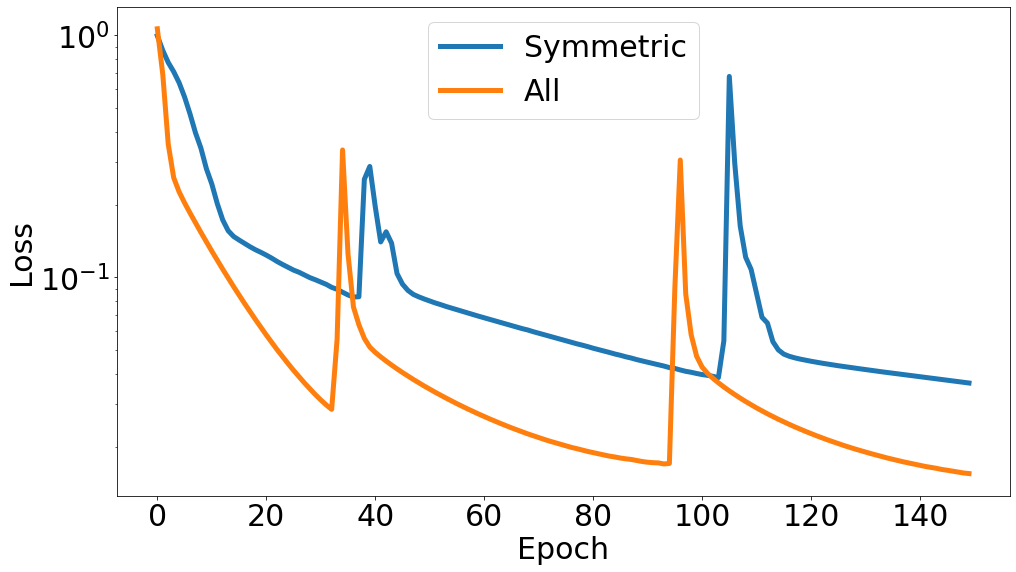

In [36]:
LabelSize=30

plt.figure(1)
plt.figure(figsize=(16,9))
plt.plot(history_sym.history['loss'],label='Symmetric',linewidth=5)
# plt.plot(history_random.history['loss'],label='Random',linewidth=5)
plt.plot(history_all.history['loss'],label='All',linewidth=5)
plt.yscale('log')
plt.ylabel('Loss',fontsize=LabelSize)
plt.xlabel('Epoch',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize)

plt.show()

<Figure size 432x288 with 0 Axes>

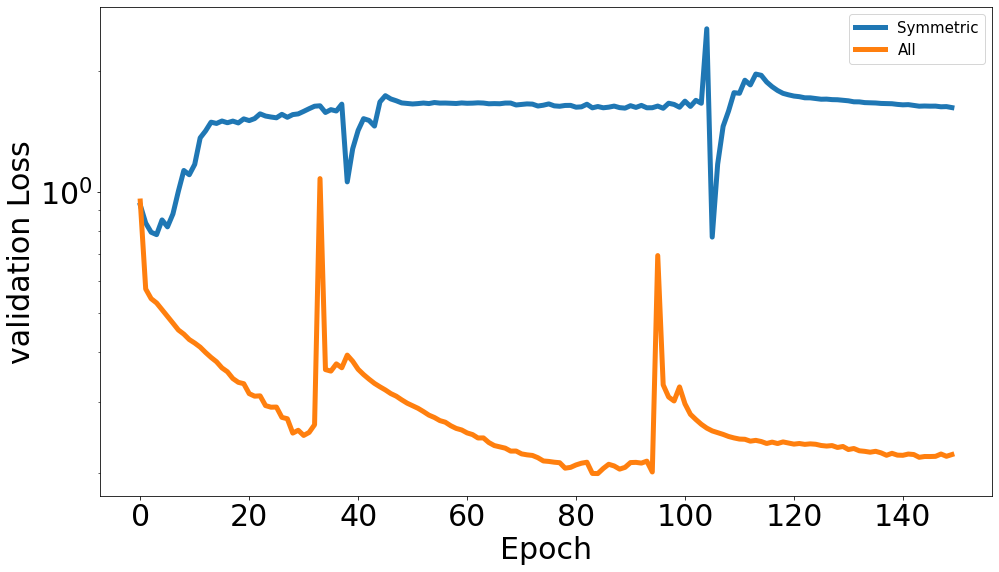

In [37]:
LabelSize=30

plt.figure(1)
plt.figure(figsize=(16,9))
plt.plot(history_sym.history['val_loss'],label='Symmetric',linewidth=5)
# plt.plot(history_random.history['val_loss'],label='Random',linewidth=5)
plt.plot(history_all.history['val_loss'],label='All',linewidth=5)
plt.yscale('log')
plt.ylabel('validation Loss',fontsize=LabelSize)
plt.xlabel('Epoch',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=0.5*LabelSize)

plt.show()

<Figure size 432x288 with 0 Axes>

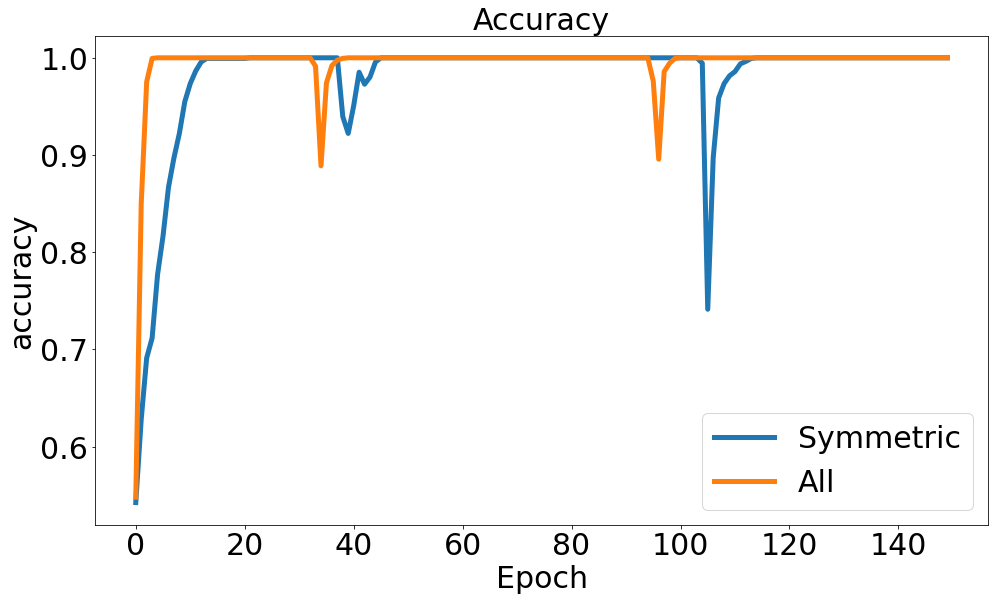

In [38]:
plt.figure(1)
plt.figure(figsize=(16,9))
plt.plot(history_sym.history['accuracy'],label='Symmetric',linewidth=5)
#plt.plot(history_random.history['accuracy'],label='Random',linewidth=5)
plt.plot(history_all.history['accuracy'],label='All',linewidth=5)
#plt.yscale('log')
plt.title('Accuracy',fontsize=LabelSize)
plt.ylabel('accuracy',fontsize=LabelSize)
plt.xlabel('Epoch',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize)
#plt.savefig("validation_acc_L{}".format(L))
plt.show()

<Figure size 432x288 with 0 Axes>

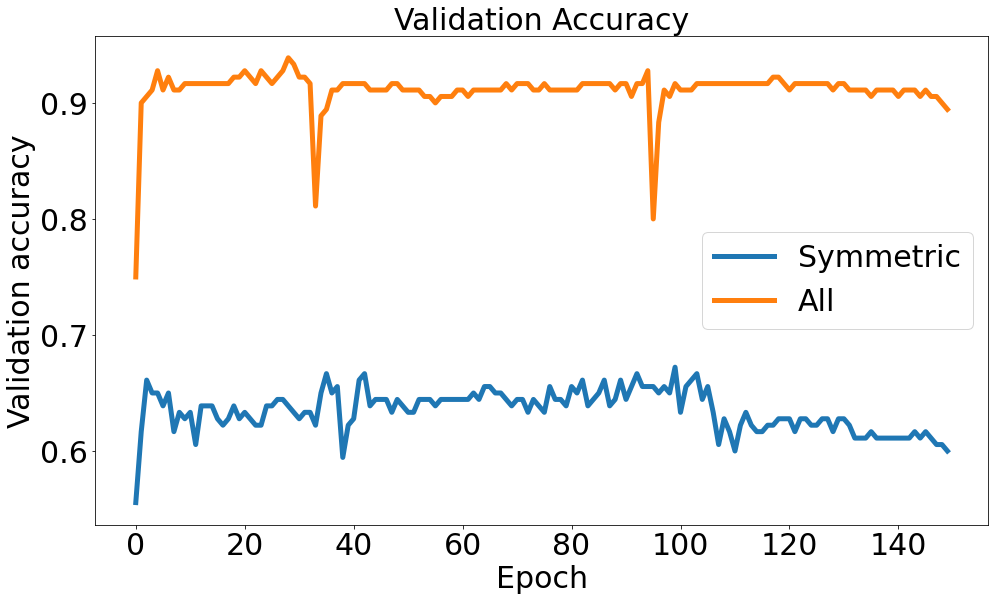

In [39]:
plt.figure(1)
plt.figure(figsize=(16,9))
plt.plot(history_sym.history['val_accuracy'],label='Symmetric',linewidth=5)
#plt.plot(history_random.history['val_accuracy'],label='Random',linewidth=5)
plt.plot(history_all.history['val_accuracy'],label='All',linewidth=5)
#plt.yscale('log')
plt.title('Validation Accuracy',fontsize=LabelSize)
plt.ylabel('Validation accuracy',fontsize=LabelSize)
plt.xlabel('Epoch',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize)
#plt.savefig("validation_acc_L{}".format(L))
plt.show()

In [40]:
X_test_all

,IIIX,IIIY,IIIZ,IIXI,IIXX,IIXY,IIXZ,IIYI,IIYX,IIYY,...,ZZXY,ZZXZ,ZZYI,ZZYX,ZZYY,ZZYZ,ZZZI,ZZZX,ZZZY,ZZZZ
1860,0.193307,-0.258131,0.114664,-0.148281,0.323279,0.318526,0.374165,-0.216737,-0.187778,0.608528,...,-0.251435,-0.301129,0.184814,0.135575,-0.485864,0.326793,-0.153007,-0.596418,0.088998,0.362091
353,-0.314665,-0.089617,-0.491812,0.176115,0.157263,-0.028551,-0.339012,0.169114,-0.309278,-0.132250,...,-0.063698,-0.001563,0.058617,-0.112970,-0.077083,0.026170,0.126756,0.271514,0.107645,-0.021204
1333,-0.131654,-0.057233,0.111355,0.034030,0.167981,-0.560633,0.104522,0.070472,-0.532903,-0.604298,...,0.079178,-0.059172,0.166802,0.163475,0.096511,0.098188,-0.235618,0.048722,-0.092555,-0.096775
905,-0.259663,0.175818,-0.408606,-0.066969,0.131810,0.084026,-0.180061,0.253164,-0.167639,-0.252058,...,-0.243720,0.203896,-0.397060,0.252209,0.014500,0.083563,-0.043024,-0.003076,0.372514,0.308804
1289,-0.079386,-0.030036,-0.164029,0.069567,0.545592,0.178534,-0.194757,0.059848,-0.011852,0.296464,...,0.150934,0.061952,0.185986,-0.115194,0.035413,0.251523,-0.223372,-0.048396,0.270734,-0.130521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,0.592473,-0.436318,-0.223807,0.175431,0.102762,-0.276925,0.088104,-0.612472,-0.607870,0.167560,...,0.132141,0.143055,0.541161,0.301540,-0.199656,-0.341538,-0.163697,-0.237945,0.169811,-0.125062
1105,0.176873,0.218447,0.417729,0.009272,0.173516,0.173218,-0.139636,0.018716,0.175536,-0.073141,...,-0.328499,0.010015,0.226509,-0.158714,0.289065,0.282914,0.340567,-0.222356,0.078730,0.067911
855,0.201403,0.175368,0.132163,0.125655,-0.131253,0.781155,-0.120748,0.051551,-0.314552,0.125087,...,-0.395549,-0.125770,-0.147271,0.457960,0.103998,-0.167672,0.130016,0.159424,0.251250,0.456803
693,-0.164775,-0.394881,0.272362,0.383651,0.116714,-0.440498,0.470185,-0.405616,0.236524,-0.028045,...,0.288724,0.002544,0.115309,-0.220222,-0.141775,0.295713,0.116084,-0.070093,0.075186,0.311401


In [132]:
explainer = shap.Explainer(model_all, X_test_all.to_numpy())
max_evals = 1000
shap_values = explainer(X_test_all,max_evals = max_evals )

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [42]:
# #If we are only interested in the SHAP values, we can use the 
# shap_values = explainer.shap_values(X_test_all)

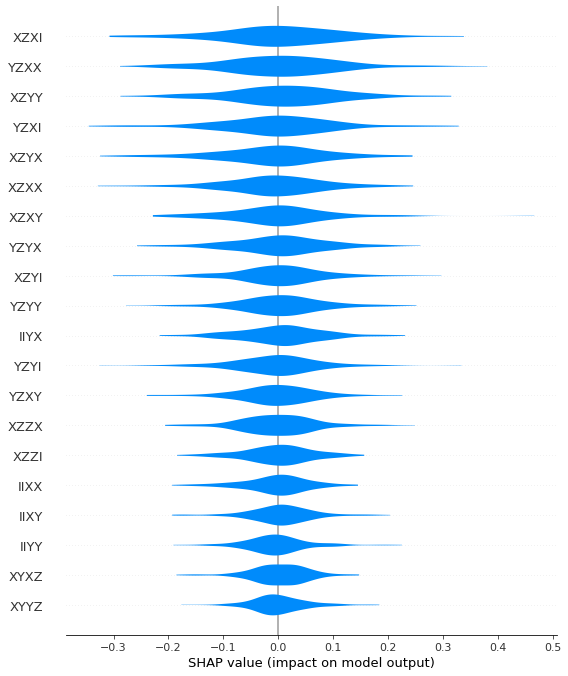

In [76]:
shap.summary_plot(shap_values,features = ob_list4_string, plot_type='violin')

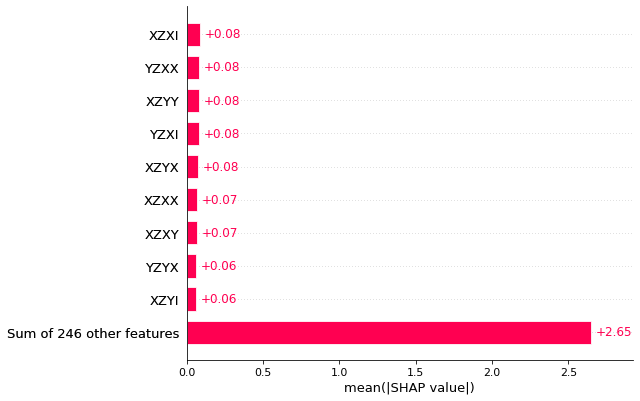

In [77]:
shap.plots.bar(shap_values)

In [78]:
shap_abs = abs(shap_values.values).mean(axis=0)

In [133]:
ind =np.where(shap_abs > np.quantile(shap_abs,0.7))

In [134]:
ind[0].shape

(77,)

In [135]:
ob_top = []

for i in range(len(ob_list4)):
    if i in ind[0]:
        ob_top.append(ob_list4[i])
    

In [136]:
ob_top

[SparsePauliOp(['IIIX'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIXI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIXX'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIXY'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIXZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIYX'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIYY'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIYZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIZI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIZZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IXXI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IXYI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IXYZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IYXI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IYXX'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IYXY'],
               coeffs=[1.+0.j]),
 SparsePauliOp

In [137]:
n_samples = 1000
param_init_list = []
info_top_list = []
info_all_list = []
output_list = []

for i in range(n_samples):
    if i%10==0:
        print(i," samples prepared")
    param_init=2*np.pi*np.random.rand(qc_init.num_parameters)
    #params_all = np.concatenate([VQA_params,param_init])
    params_all = np.concatenate([param_init,VQA_params])

    info_top = estimator.run([qc_init]*len(ob_top),observables=ob_top,parameter_values=[param_init]*len(ob_top)).result().values
    info_all = estimator.run([qc_init]*len(ob_list4),observables=ob_list4,parameter_values=[param_init]*len(ob_list4)).result().values
    output = estimator.run(qc,observables=ob,parameter_values=params_all).result().values[0]

    param_init_list.append(param_init)
 
    info_top_list.append(info_top)
    info_all_list.append(info_all)
    output_list.append(output)


info_top_list = np.array(info_top_list)
info_all_list = np.array(info_all_list)
output_list = np.array(output_list)
    
#turning into classification problem:
output_list=np.floor(output_list)+1
    
    

0  samples prepared
10  samples prepared
20  samples prepared
30  samples prepared
40  samples prepared
50  samples prepared
60  samples prepared
70  samples prepared
80  samples prepared
90  samples prepared
100  samples prepared
110  samples prepared
120  samples prepared
130  samples prepared
140  samples prepared
150  samples prepared
160  samples prepared
170  samples prepared
180  samples prepared
190  samples prepared
200  samples prepared
210  samples prepared
220  samples prepared
230  samples prepared
240  samples prepared
250  samples prepared
260  samples prepared
270  samples prepared
280  samples prepared
290  samples prepared
300  samples prepared
310  samples prepared
320  samples prepared
330  samples prepared
340  samples prepared
350  samples prepared
360  samples prepared
370  samples prepared
380  samples prepared
390  samples prepared
400  samples prepared
410  samples prepared
420  samples prepared
430  samples prepared
440  samples prepared
450  samples prepared

In [128]:
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
       info_top_list, output_list, test_size=0.1, random_state=42)


X_train_all, X_test_all, y_train_all, y_test_all= train_test_split(
       info_all_list, output_list, test_size=0.1, random_state=42)




In [131]:
model_top,history_top=train(X_train_top[0:maxEvents],y_train_top[0:maxEvents])


Epoch 1/150
13/13 [==============================] - 0s 7ms/step - loss: 1.0442 - binary_crossentropy: 0.6939 - accuracy: 0.5371 - val_loss: 1.0275 - val_binary_crossentropy: 0.6964 - val_accuracy: 0.5556
Epoch 2/150
13/13 [==============================] - 0s 2ms/step - loss: 0.9901 - binary_crossentropy: 0.6732 - accuracy: 0.6337 - val_loss: 1.0044 - val_binary_crossentropy: 0.7040 - val_accuracy: 0.4889
Epoch 3/150
13/13 [==============================] - 0s 2ms/step - loss: 0.9343 - binary_crossentropy: 0.6453 - accuracy: 0.7104 - val_loss: 0.9827 - val_binary_crossentropy: 0.7066 - val_accuracy: 0.5111
Epoch 4/150
13/13 [==============================] - 0s 1ms/step - loss: 0.8592 - binary_crossentropy: 0.5916 - accuracy: 0.7401 - val_loss: 1.0008 - val_binary_crossentropy: 0.7422 - val_accuracy: 0.5111
Epoch 5/150
13/13 [==============================] - 0s 2ms/step - loss: 0.7610 - binary_crossentropy: 0.5079 - accuracy: 0.7723 - val_loss: 1.0106 - val_binary_crossentropy: 0.763

Epoch 41/150
13/13 [==============================] - 0s 2ms/step - loss: 0.1198 - binary_crossentropy: 0.0038 - accuracy: 1.0000 - val_loss: 1.7908 - val_binary_crossentropy: 1.6762 - val_accuracy: 0.6444
Epoch 42/150
13/13 [==============================] - 0s 2ms/step - loss: 0.1173 - binary_crossentropy: 0.0038 - accuracy: 1.0000 - val_loss: 1.7524 - val_binary_crossentropy: 1.6401 - val_accuracy: 0.6667
Epoch 43/150
13/13 [==============================] - 0s 2ms/step - loss: 0.1147 - binary_crossentropy: 0.0036 - accuracy: 1.0000 - val_loss: 1.8172 - val_binary_crossentropy: 1.7075 - val_accuracy: 0.6444
Epoch 44/150
13/13 [==============================] - 0s 2ms/step - loss: 0.1123 - binary_crossentropy: 0.0036 - accuracy: 1.0000 - val_loss: 1.7792 - val_binary_crossentropy: 1.6718 - val_accuracy: 0.6444
Epoch 45/150
13/13 [==============================] - 0s 2ms/step - loss: 0.1099 - binary_crossentropy: 0.0035 - accuracy: 1.0000 - val_loss: 1.7696 - val_binary_crossentropy: 

Epoch 81/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0551 - binary_crossentropy: 0.0025 - accuracy: 1.0000 - val_loss: 1.5217 - val_binary_crossentropy: 1.4696 - val_accuracy: 0.6444
Epoch 82/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0542 - binary_crossentropy: 0.0025 - accuracy: 1.0000 - val_loss: 1.5367 - val_binary_crossentropy: 1.4854 - val_accuracy: 0.6667
Epoch 83/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0533 - binary_crossentropy: 0.0024 - accuracy: 1.0000 - val_loss: 1.5216 - val_binary_crossentropy: 1.4713 - val_accuracy: 0.6444
Epoch 84/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0525 - binary_crossentropy: 0.0024 - accuracy: 1.0000 - val_loss: 1.5386 - val_binary_crossentropy: 1.4890 - val_accuracy: 0.6444
Epoch 85/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0517 - binary_crossentropy: 0.0024 - accuracy: 1.0000 - val_loss: 1.5188 - val_binary_crossentropy: 

Epoch 121/150
13/13 [==============================] - 0s 1ms/step - loss: 0.0332 - binary_crossentropy: 0.0020 - accuracy: 1.0000 - val_loss: 1.3789 - val_binary_crossentropy: 1.3479 - val_accuracy: 0.6889
Epoch 122/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0330 - binary_crossentropy: 0.0021 - accuracy: 1.0000 - val_loss: 1.3811 - val_binary_crossentropy: 1.3503 - val_accuracy: 0.6444
Epoch 123/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0327 - binary_crossentropy: 0.0021 - accuracy: 1.0000 - val_loss: 1.3766 - val_binary_crossentropy: 1.3462 - val_accuracy: 0.6222
Epoch 124/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0325 - binary_crossentropy: 0.0022 - accuracy: 1.0000 - val_loss: 1.3880 - val_binary_crossentropy: 1.3577 - val_accuracy: 0.6667
Epoch 125/150
13/13 [==============================] - 0s 1ms/step - loss: 0.0321 - binary_crossentropy: 0.0020 - accuracy: 1.0000 - val_loss: 1.3420 - val_binary_crossentr

In [130]:
model_all,history_all=train(X_train_all[0:maxEvents],y_train_all[0:maxEvents])

Epoch 1/150
13/13 [==============================] - 0s 9ms/step - loss: 1.1247 - binary_crossentropy: 0.6981 - accuracy: 0.4604 - val_loss: 1.0960 - val_binary_crossentropy: 0.6881 - val_accuracy: 0.5333
Epoch 2/150
13/13 [==============================] - 0s 2ms/step - loss: 1.0534 - binary_crossentropy: 0.6598 - accuracy: 0.7178 - val_loss: 1.0595 - val_binary_crossentropy: 0.6824 - val_accuracy: 0.5333
Epoch 3/150
13/13 [==============================] - 0s 3ms/step - loss: 0.9520 - binary_crossentropy: 0.5858 - accuracy: 0.8218 - val_loss: 1.0077 - val_binary_crossentropy: 0.6529 - val_accuracy: 0.5333
Epoch 4/150
13/13 [==============================] - 0s 2ms/step - loss: 0.7184 - binary_crossentropy: 0.3696 - accuracy: 0.9010 - val_loss: 0.9507 - val_binary_crossentropy: 0.6079 - val_accuracy: 0.6889
Epoch 5/150
13/13 [==============================] - 0s 2ms/step - loss: 0.4690 - binary_crossentropy: 0.1297 - accuracy: 0.9653 - val_loss: 1.0755 - val_binary_crossentropy: 0.740

Epoch 41/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0707 - binary_crossentropy: 0.0017 - accuracy: 1.0000 - val_loss: 0.8222 - val_binary_crossentropy: 0.7547 - val_accuracy: 0.8000
Epoch 42/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0681 - binary_crossentropy: 0.0017 - accuracy: 1.0000 - val_loss: 0.8199 - val_binary_crossentropy: 0.7550 - val_accuracy: 0.8000
Epoch 43/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0655 - binary_crossentropy: 0.0017 - accuracy: 1.0000 - val_loss: 0.8066 - val_binary_crossentropy: 0.7441 - val_accuracy: 0.8000
Epoch 44/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0631 - binary_crossentropy: 0.0017 - accuracy: 1.0000 - val_loss: 0.8065 - val_binary_crossentropy: 0.7463 - val_accuracy: 0.8000
Epoch 45/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0608 - binary_crossentropy: 0.0016 - accuracy: 1.0000 - val_loss: 0.8058 - val_binary_crossentropy: 

Epoch 81/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0222 - binary_crossentropy: 0.0013 - accuracy: 1.0000 - val_loss: 0.7160 - val_binary_crossentropy: 0.6953 - val_accuracy: 0.7778
Epoch 82/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0218 - binary_crossentropy: 0.0013 - accuracy: 1.0000 - val_loss: 0.7157 - val_binary_crossentropy: 0.6954 - val_accuracy: 0.7778
Epoch 83/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0214 - binary_crossentropy: 0.0013 - accuracy: 1.0000 - val_loss: 0.7201 - val_binary_crossentropy: 0.7002 - val_accuracy: 0.7778
Epoch 84/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0210 - binary_crossentropy: 0.0013 - accuracy: 1.0000 - val_loss: 0.7005 - val_binary_crossentropy: 0.6809 - val_accuracy: 0.8000
Epoch 85/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0207 - binary_crossentropy: 0.0012 - accuracy: 1.0000 - val_loss: 0.7245 - val_binary_crossentropy: 

Epoch 121/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0143 - binary_crossentropy: 0.0010 - accuracy: 1.0000 - val_loss: 0.7528 - val_binary_crossentropy: 0.7396 - val_accuracy: 0.7556
Epoch 122/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0143 - binary_crossentropy: 0.0011 - accuracy: 1.0000 - val_loss: 0.7769 - val_binary_crossentropy: 0.7637 - val_accuracy: 0.7556
Epoch 123/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0142 - binary_crossentropy: 9.8526e-04 - accuracy: 1.0000 - val_loss: 0.7836 - val_binary_crossentropy: 0.7704 - val_accuracy: 0.7778
Epoch 124/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0141 - binary_crossentropy: 0.0010 - accuracy: 1.0000 - val_loss: 0.7639 - val_binary_crossentropy: 0.7510 - val_accuracy: 0.7778
Epoch 125/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0141 - binary_crossentropy: 0.0011 - accuracy: 1.0000 - val_loss: 0.8114 - val_binary_cross